In [1]:
#pip install kaggle --upgrade

In [2]:
#!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [3]:
#!kaggle competitions list

ref                                                                               deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/llm-detect-ai-generated-text                  2024-01-22 23:59:00  Featured          $110,000       3096           False  
https://www.kaggle.com/competitions/nfl-big-data-bowl-2024                        2024-01-08 23:59:00  Analytics         $100,000          0           False  
https://www.kaggle.com/competitions/blood-vessel-segmentation                     2024-02-06 23:59:00  Research           $80,000        398           False  
https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality  2024-01-09 23:59:00  Featured           $55,000       1694           False  
https://www.kaggle.com/competitions/UBC-OCEAN 

In [4]:
#!kaggle datasets download -d puneet6060/intel-image-classification

 95% 330M/346M [00:02<00:00, 180MB/s]
100% 346M/346M [00:02<00:00, 161MB/s]


In [5]:
#!unzip intel-image-classification.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train

In [6]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.1.0+cu121'

In [7]:
import os
import glob
import random
import numpy as np
import seaborn as sns
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [8]:
import torchvision.models as models

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
train_dir = "seg_test/seg_test"
test_dir = "seg_train/seg_train"
train_dir, test_dir

('seg_test/seg_test', 'seg_train/seg_train')

Random image path: seg_train/seg_train/street/1042.jpg
Image class: street
Image height: 150
Image width: 150


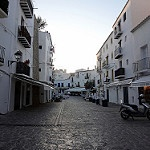

In [12]:


# Set seed
random.seed(42)

# 1. Obtenir tous les chemins d'accès aux images (* signifie "toute combinaison")
image_path_list= glob.glob(f"{test_dir}/*/*.jpg")

# 2. Obtenir un chemin d'accès aléatoire à l'image
random_image_path = random.choice(image_path_list)

# 3. Obtenir la classe d'image à partir du nom du chemin (la classe d'image est le nom du répertoire dans lequel l'image est stockée)
image_class = Path(random_image_path).parent.stem

# 4. Ouvrir l'image
img = Image.open(random_image_path)

# 5. Imprimer les métadonnées
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

# Transformer les données

La transformation des données, également connue sous le nom de prétraitement, est une étape importante dans l'analyse de l'apprentissage profond car elle peut aider à améliorer les performances du modèle et à réduire le risque de biais. Jouons un peu avec les images grâce à la méthode `transform`.

In [13]:

# Ecriture d'une transformation pour l'image
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Pour comprendre comment transformer les images, utilisons la visualisation des données. Pour ce faire, je vais créer une fonction appelée plot_transformed_images.

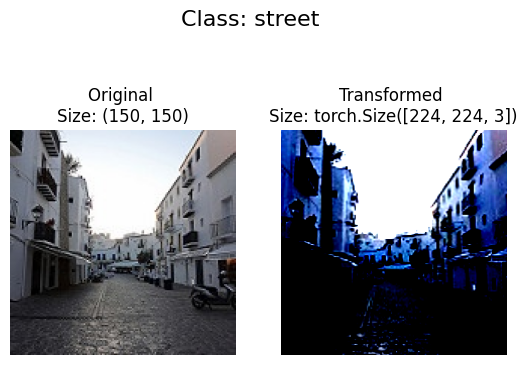

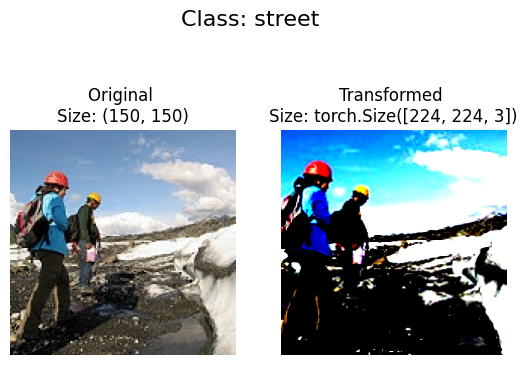

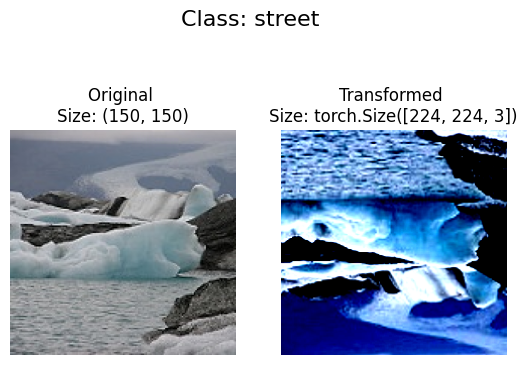

In [14]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transformer et tracer l'image
            # Note : permute() changera la forme de l'image pour l'adapter à matplotlib
            # (la valeur par défaut de PyTorch est [C, H, W] mais celle de Matplotlib est [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

# Chargement des données d'une image
Jusqu'à présent, nous avons créé une fonction de transformation de données. Nous sommes prêts à charger notre jeu de données à l'aide de cette fonction. La façon la plus simple de charger des données est d'utiliser la fonction `ImageFolder` de PyTorch. Chargeons le jeu de données avec cette fonction.

In [15]:
from torchvision import datasets

# Création d'un ensemble d'entraînement
train_data = datasets.ImageFolder(root=train_dir, # dossier cible des images
                                  transform=data_transform, # Transformations à effectuer sur les données (images)
                                  target_transform=None) # Transformations à effectuer sur les étiquettes (si nécessaire)
#Création d'une série de tests
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 3000
    Root location: seg_test/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 14034
    Root location: seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [16]:
# Obtenir les noms des classes sous forme de liste
class_names = train_data.classes
print("Class names: ",class_names)
# Peut également obtenir les noms de classe sous forme de dict
class_dict = train_data.class_to_idx
print("Class names as a dict: ",class_dict)

# Vérifiez les longueurs
print("Longueur des ensembles d'apprentissage et de test: ", len(train_data), len(test_data))

Class names:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Class names as a dict:  {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Longueur des ensembles d'apprentissage et de test:  3000 14034


## Transformer les images chargées en images DataLoader

Jusqu'à présent, nous avons chargé des images. Notez qu'un `DataLoader` dans PyTorch est un utilitaire utilisé pour charger des données à partir d'un objet dataset en parallèle. Il permet à l'utilisateur de charger des données par lots, ce qui peut être utile pour la formation des modèles d'apprentissage profond, car cela permet au modèle de traiter plusieurs échantillons à la fois, ce qui peut accélérer le processus de formation. En outre, il permet également à l'utilisateur de mélanger les données, ce qui peut aider à prévenir le surajustement.

Le DataLoader prend un objet dataset et plusieurs autres paramètres optionnels, tels que la taille du lot, le nombre de threads de travail à utiliser pour charger les données et un drapeau booléen indiquant s'il faut ou non mélanger les données. Le DataLoader renvoie alors un itérateur qui peut être utilisé pour parcourir les données par lots.


In [17]:
# Transformez les ensembles de données d'entraînement et de test en DataLoaders

bs=128
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=bs,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=bs,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c9d89c2dba0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c9d89c2d3c0>)

In [18]:
# Initialiser le modèle, la fonction de perte et l'optimiseur


# Chargement du modèle VIT 17 pré-entraîné
vit16 = models.vit_b_16(pretrained=True).cuda()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 84.5MB/s]


# Formation partielle sur le modèle

In [19]:
# # Création d'un classificateur d'images basé sur le CNN.
class CLS(nn.Module):
    def __init__(self):
        super().__init__()

        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=768, out_features=1024),
          nn.ReLU(),
          nn.Linear(in_features=1024, out_features=512),
          nn.ReLU(),
          nn.Linear(in_features=512, out_features=2),

          )
    def forward(self, x):

        x=nn.Flatten()(x)
        x = self.classifier(x)
        return x

In [ ]:
features.shape

NameError: ignored

In [20]:


model = CLS().cuda()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [21]:
# Former le modèle
train_loss=[]
test_accuracy=[]
best_accuracy=-np.inf
num_epochs = 10
for epoch in range(num_epochs):

    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()

        with torch.no_grad():
                  x = vit16._process_input(inputs)
                  n = x.shape[0]

                  # Étendre le jeton de classe à l'ensemble du lot
                  batch_class_token = vit16.class_token.expand(n, -1, -1)
                  x = torch.cat([batch_class_token, x], dim=1)

                  x = vit16.encoder(x)

                  # Le classificateur "token" tel qu'il est utilisé par les architectures linguistiques standard
                  features = x[:, 0].detach()

        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0
    train_loss.append(running_loss/(i+1))
    # Tester le modèle
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()

            with torch.no_grad():
                  x = vit16._process_input(inputs)
                  n = x.shape[0]

                  # Étendre le jeton de classe à l'ensemble du lot
                  batch_class_token = vit16.class_token.expand(n, -1, -1)
                  x = torch.cat([batch_class_token, x], dim=1)

                  x = vit16.encoder(x)

                  # Le classificateur "token" tel qu'il est utilisé par les architectures linguistiques standard
                  features = x[:, 0].detach()


            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    test_accuracy.append(accuracy)
    print('Précision du réseau a lepoch %d sur les images tests:'%(epoch+1) ,100 * accuracy)
    if accuracy > best_accuracy:
      best_accuracy=accuracy
      torch.save(model.state_dict(), 'CNN.pth')



print('Formation terminée')

RuntimeError: ignored